# Train a model for classifying tissue samples into benign vs malign

## Import needed libraries

In [1]:
# download from urls
import urllib.request

import os
import tarfile
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Uncomment the following line to install Pillow if not already installed
# !pip install --upgrade pillow

# Verify Pillow installation
from PIL import Image
import PIL
print("Pillow version:", PIL.__version__)

Pillow version: 10.3.0


## Get the data ready

### Download the images

In [6]:
# Download the 56 zip files in Images_png in batches
# URLs for the zip files
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
	'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
	'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
	'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
	'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
	'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
	'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
	'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]


for idx, link in enumerate(links):
    fn = '/home/cbarr23/Documents/ccir_demo/imgs/images_%02d.tar.gz' % (idx+1)
    print('downloading'+fn+'...')
    urllib.request.urlretrieve(link, fn)  # download the zip file


print("Download complete. Please check the checksums")

downloading/home/cbarr23/Documents/ccir_demo/imgs/images_01.tar.gz...
downloading/home/cbarr23/Documents/ccir_demo/imgs/images_02.tar.gz...
downloading/home/cbarr23/Documents/ccir_demo/imgs/images_03.tar.gz...
downloading/home/cbarr23/Documents/ccir_demo/imgs/images_04.tar.gz...
downloading/home/cbarr23/Documents/ccir_demo/imgs/images_05.tar.gz...
downloading/home/cbarr23/Documents/ccir_demo/imgs/images_06.tar.gz...
downloading/home/cbarr23/Documents/ccir_demo/imgs/images_07.tar.gz...
downloading/home/cbarr23/Documents/ccir_demo/imgs/images_08.tar.gz...
downloading/home/cbarr23/Documents/ccir_demo/imgs/images_09.tar.gz...
downloading/home/cbarr23/Documents/ccir_demo/imgs/images_10.tar.gz...
downloading/home/cbarr23/Documents/ccir_demo/imgs/images_11.tar.gz...
downloading/home/cbarr23/Documents/ccir_demo/imgs/images_12.tar.gz...
Download complete. Please check the checksums


### Define the paths

In [2]:
# Paths
data_dir = '/home/cbarr23/Documents/ccir_demo/imgs/'
csv_path = '/home/cbarr23/Documents/ccir_demo/Data_Entry_2017_v2020.csv'
output_dir = '/home/cbarr23/Documents/ccir_demo/processed/'
image_dir = '/home/cbarr23/Documents/ccir_demo/imgs/images/'

### Unpack the files

In [10]:
# Unpack all .tar.gz files into individual subdirectories
tar_files = [f for f in os.listdir(data_dir) if f.endswith('.tar.gz')]
for tar_file in tar_files:
    tar_path = os.path.join(data_dir, tar_file)
    subdir = os.path.join(data_dir, tar_file[:-7])  # Create subdirectory based on tar file name
    os.makedirs(subdir, exist_ok=True)
    with tarfile.open(tar_path, 'r:gz') as tar:
        tar.extractall(path=subdir)
    print(f'Unpacked {tar_file} into {subdir}')

Unpacked images_01.tar.gz into /home/cbarr23/Documents/ccir_demo/imgs/images_01
Unpacked images_02.tar.gz into /home/cbarr23/Documents/ccir_demo/imgs/images_02
Unpacked images_03.tar.gz into /home/cbarr23/Documents/ccir_demo/imgs/images_03
Unpacked images_05.tar.gz into /home/cbarr23/Documents/ccir_demo/imgs/images_05
Unpacked images_10.tar.gz into /home/cbarr23/Documents/ccir_demo/imgs/images_10
Unpacked images_09.tar.gz into /home/cbarr23/Documents/ccir_demo/imgs/images_09
Unpacked images_12.tar.gz into /home/cbarr23/Documents/ccir_demo/imgs/images_12
Unpacked images_06.tar.gz into /home/cbarr23/Documents/ccir_demo/imgs/images_06
Unpacked images_07.tar.gz into /home/cbarr23/Documents/ccir_demo/imgs/images_07
Unpacked images_04.tar.gz into /home/cbarr23/Documents/ccir_demo/imgs/images_04
Unpacked images_08.tar.gz into /home/cbarr23/Documents/ccir_demo/imgs/images_08
Unpacked images_11.tar.gz into /home/cbarr23/Documents/ccir_demo/imgs/images_11


In [11]:
# Create directories for processed data
os.makedirs(os.path.join(output_dir, 'train/normal'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'train/pneumonia'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test/normal'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test/pneumonia'), exist_ok=True)

### Load the csv file for identifying the labels for normal vs pneumonia

In [12]:
# Load CSV
df = pd.read_csv(csv_path)

### filter out for Pneumonia vs Normal

In [47]:
# Load CSV and filter images with labels 'No Finding' and 'Pneumonia'
df = pd.read_csv(csv_path)
filtered_df = df[df['Finding Labels'].isin(['No Finding', 'Pneumonia'])].copy()

# Map 'No Finding' to 'normal' and 'Pneumonia' to 'pneumonia'
filtered_df.loc[:, 'label'] = filtered_df['Finding Labels'].map({'No Finding': 'normal', 'Pneumonia': 'pneumonia'})


### Split into train and test

In [48]:
# Split into train and test sets
train_df, test_df = train_test_split(filtered_df, test_size=0.2, stratify=filtered_df['label'], random_state=42)

### copy images to corresponding folders

In [49]:
# Function to copy images to their respective directories
def copy_images(df, split):
    for _, row in df.iterrows():
        label = row['label']
        image_path = os.path.join(image_dir, row['Image Index'])
        if os.path.exists(image_path):
            shutil.copy(image_path, os.path.join(output_dir, split, label, row['Image Index']))


# Copy images to train and test directories
copy_images(train_df, 'train')
copy_images(test_df, 'test')


print("Images have been successfully filtered and organized.")

Images have been successfully filtered and organized.


## Get the model ready

### Parameters

In [14]:
# Parameters for training
img_height, img_width = 224, 224
batch_size = 32
epochs = 1

### Generate the data for the DL model training

In [15]:
# Data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    os.path.join(output_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(output_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 48546 images belonging to 2 classes.
Found 12137 images belonging to 2 classes.


### Model building

In [16]:
# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

### Combine the model

In [17]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Train the model

In [27]:
# Train the model
model.fit(train_generator, epochs=epochs, validation_data=test_generator)

2024-06-23 13:52:18.553600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1518/1518 [==============================] - ETA: 0s - loss: 0.0486 - accuracy: 0.9946

2024-06-23 14:04:48.476525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1518/1518 [==============================] - 885s 583ms/step - loss: 0.0486 - accuracy: 0.9946 - val_loss: 0.0335 - val_accuracy: 0.9947


### Save the model

In [ ]:
# Save the model
model.save('/home/cbarr23/Documents/ccir_demo/model/cxr_classification_epoch_1_model.h5')

1/1 [==============================] - 0s 122ms/step
Correct Predictions with Grad-CAM:


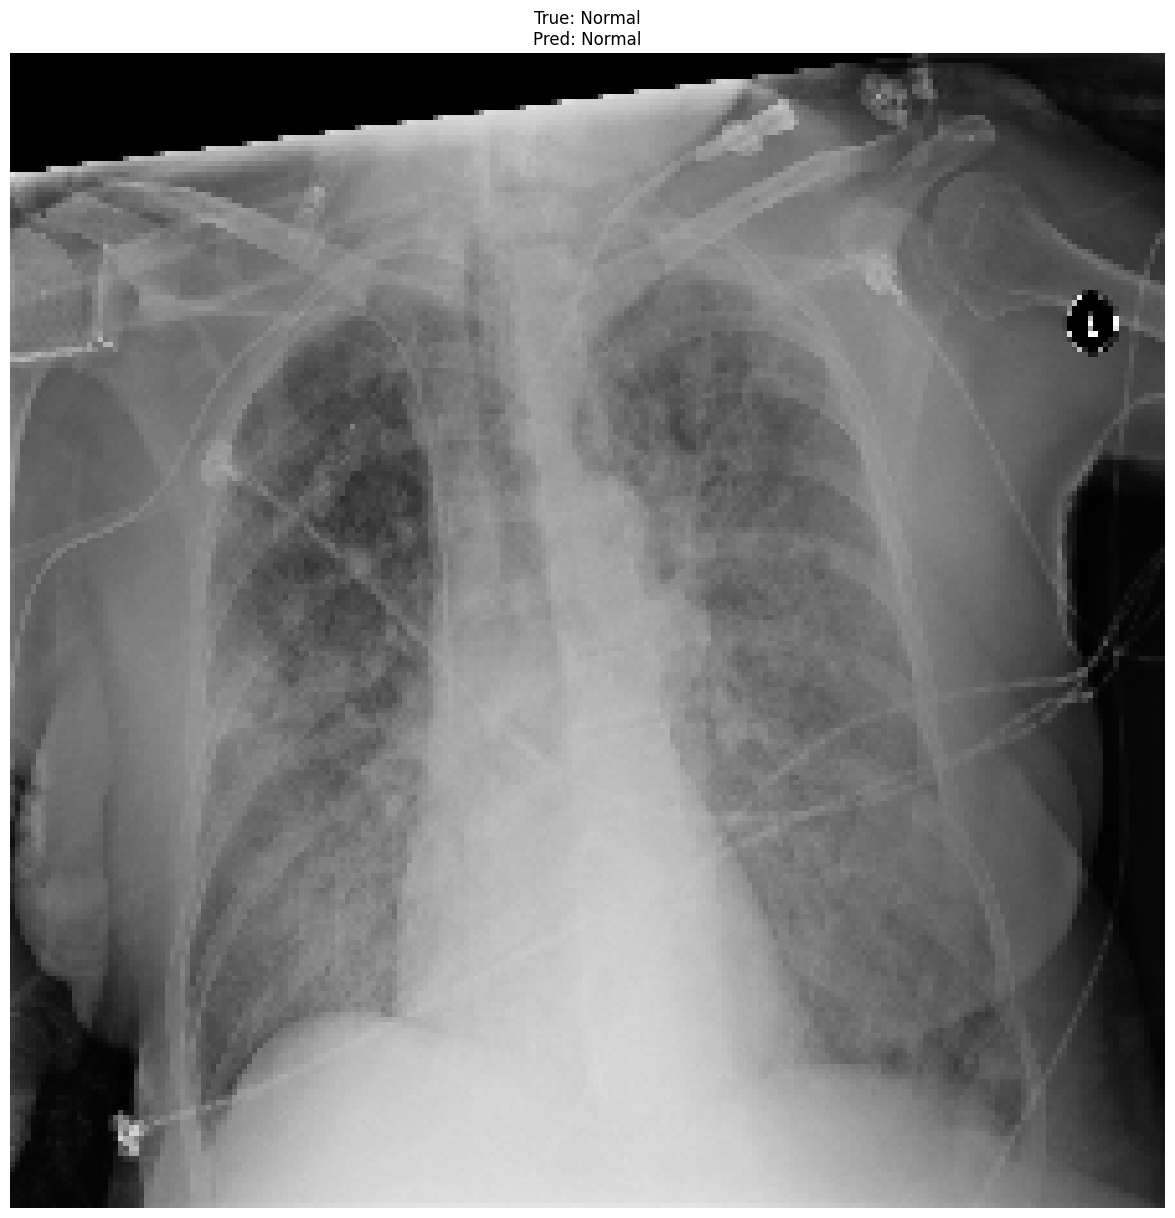

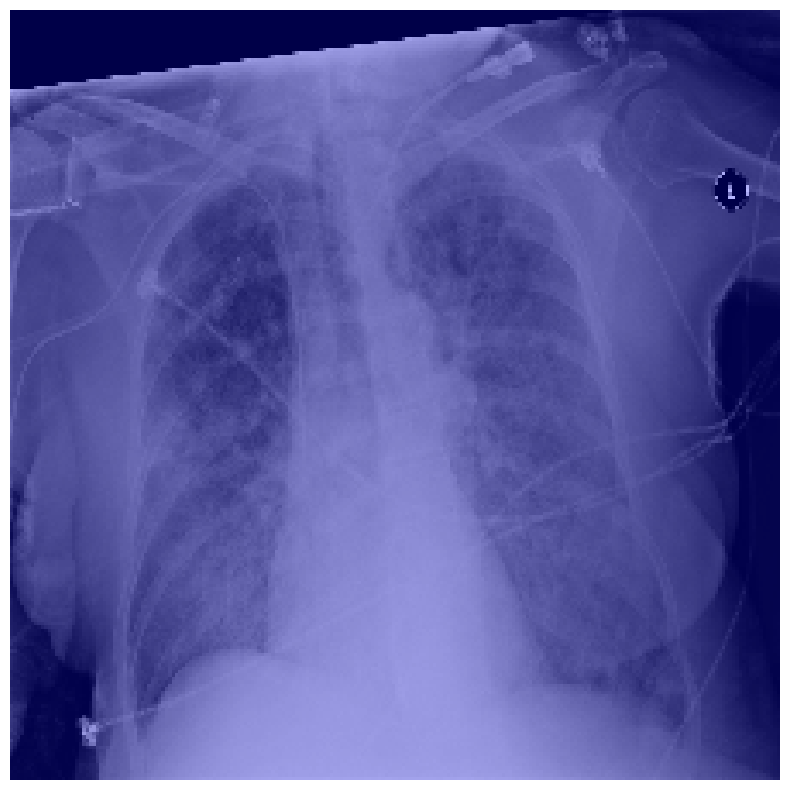

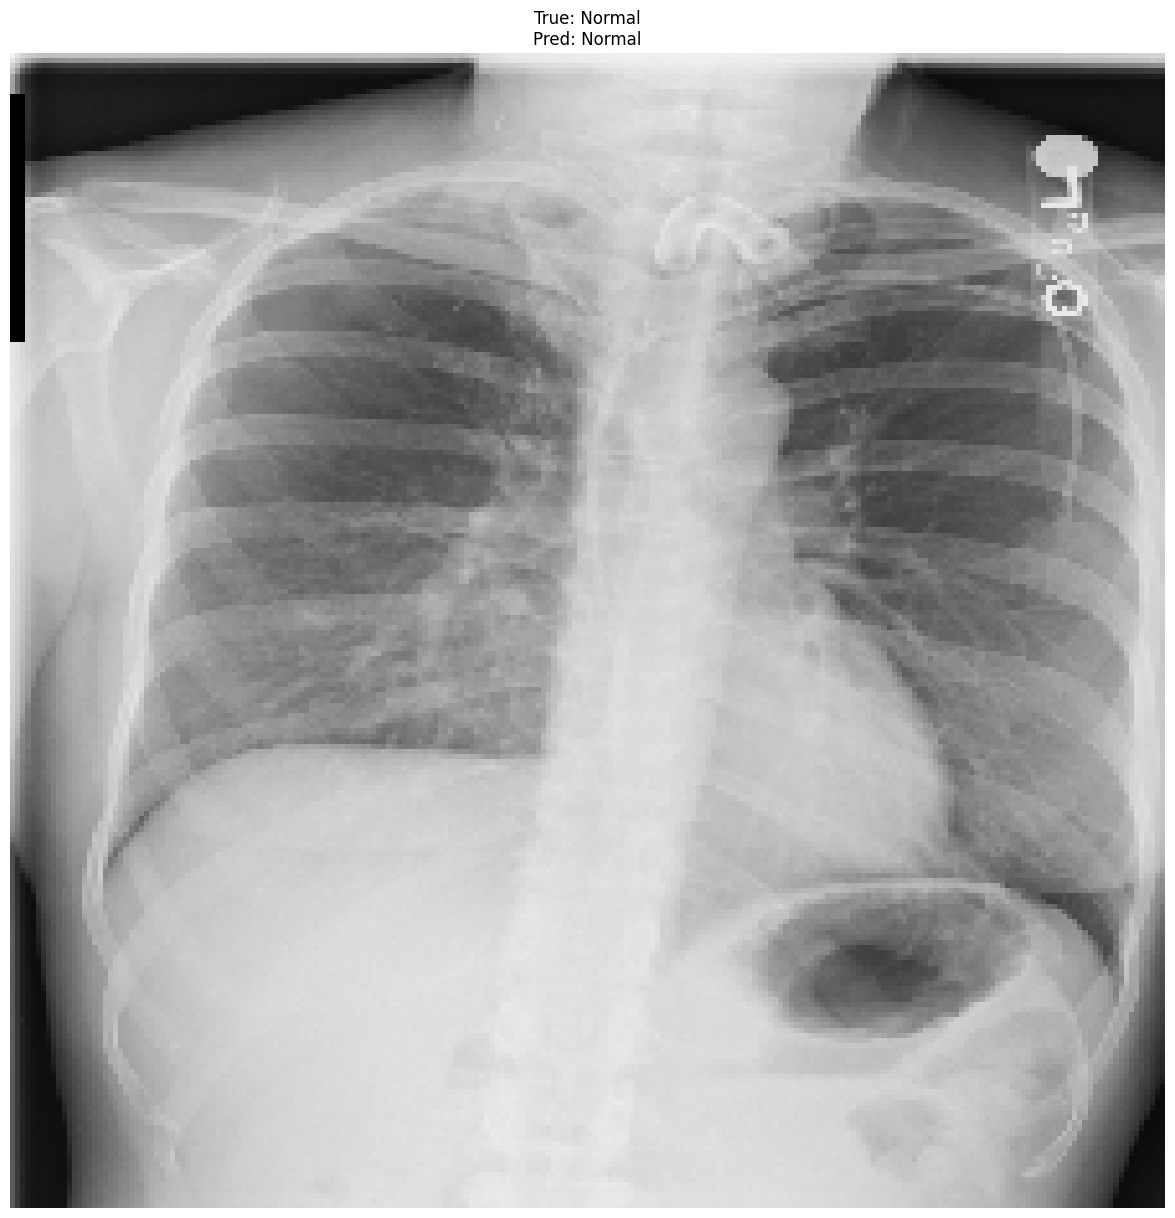

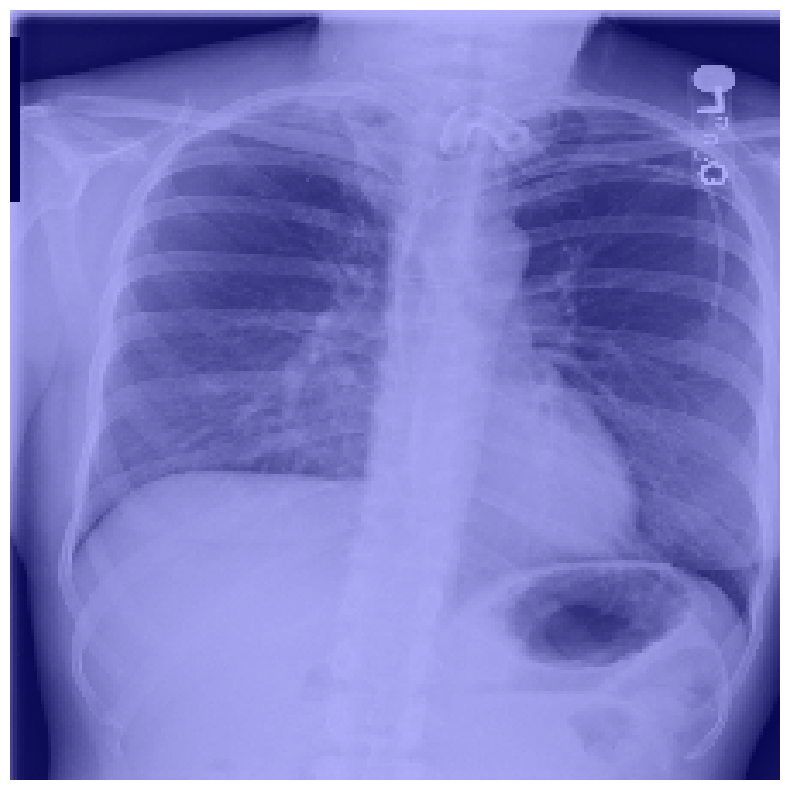

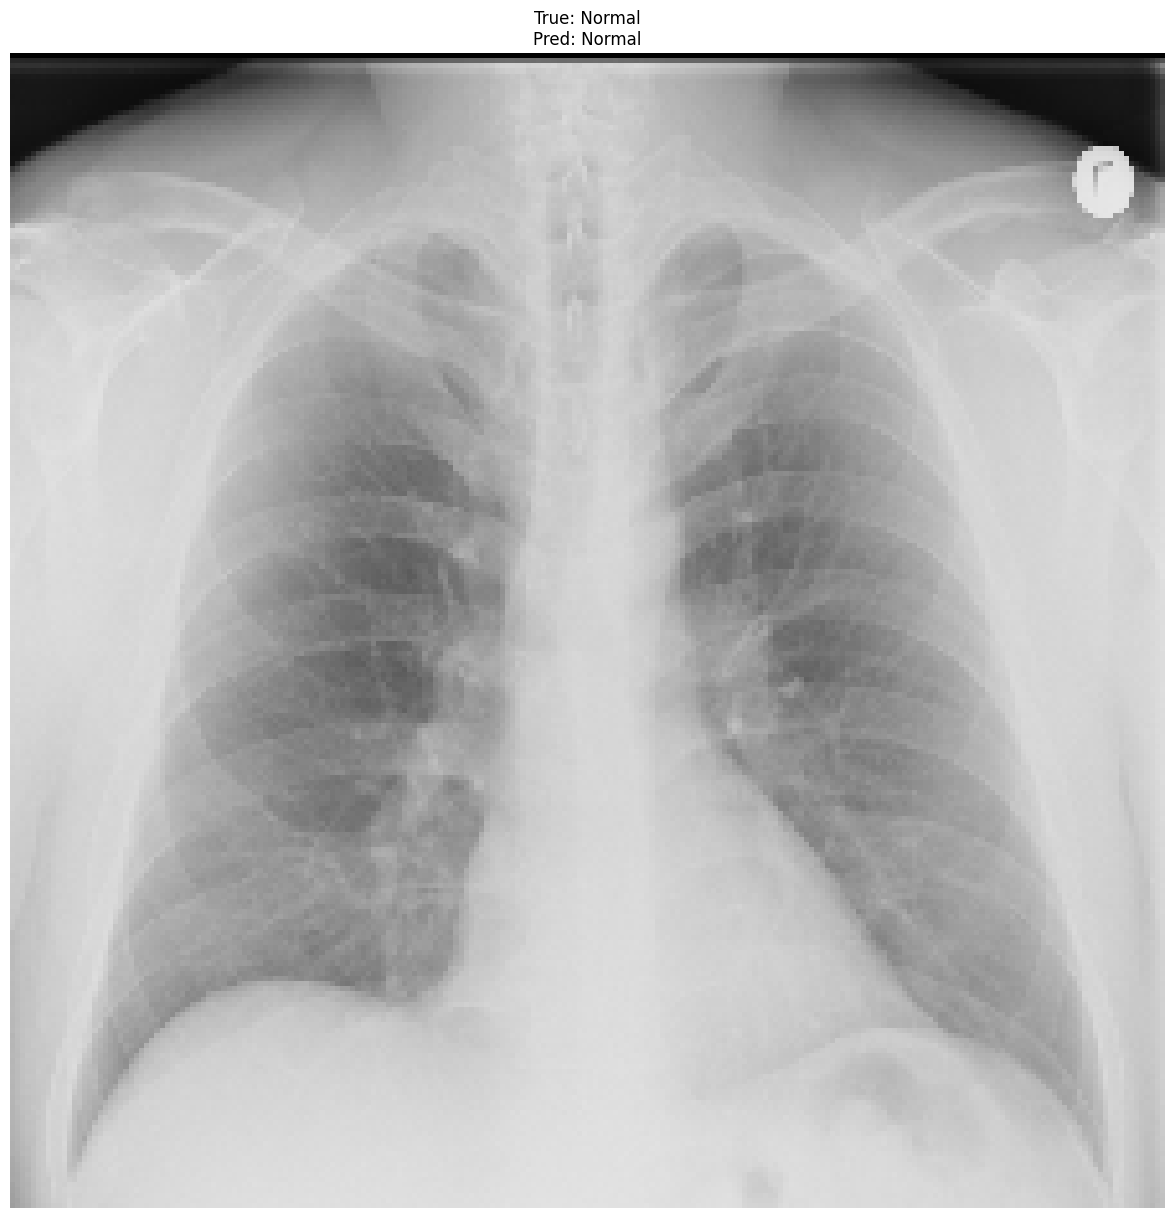

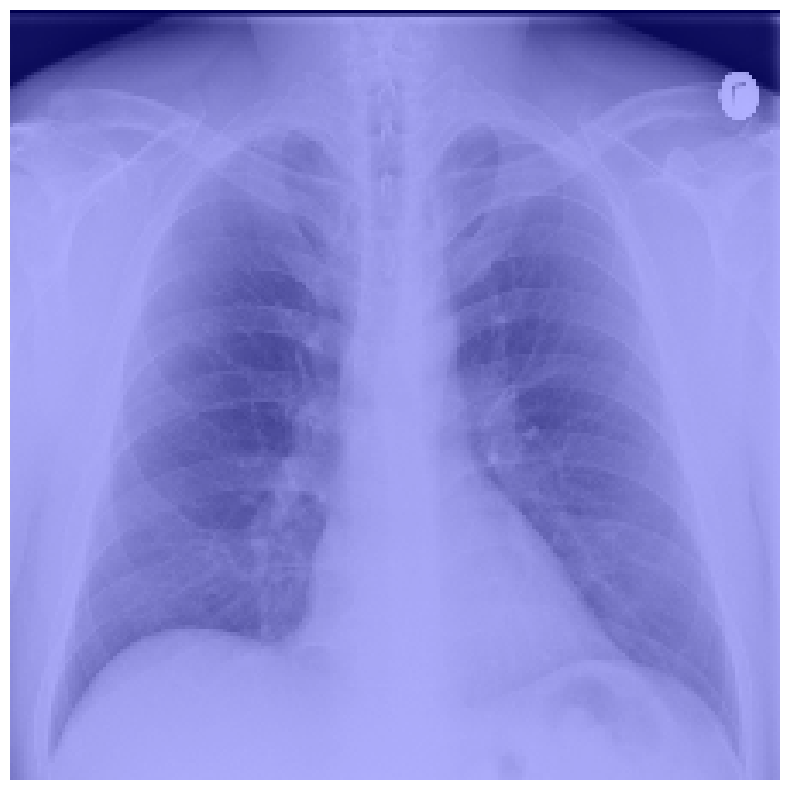

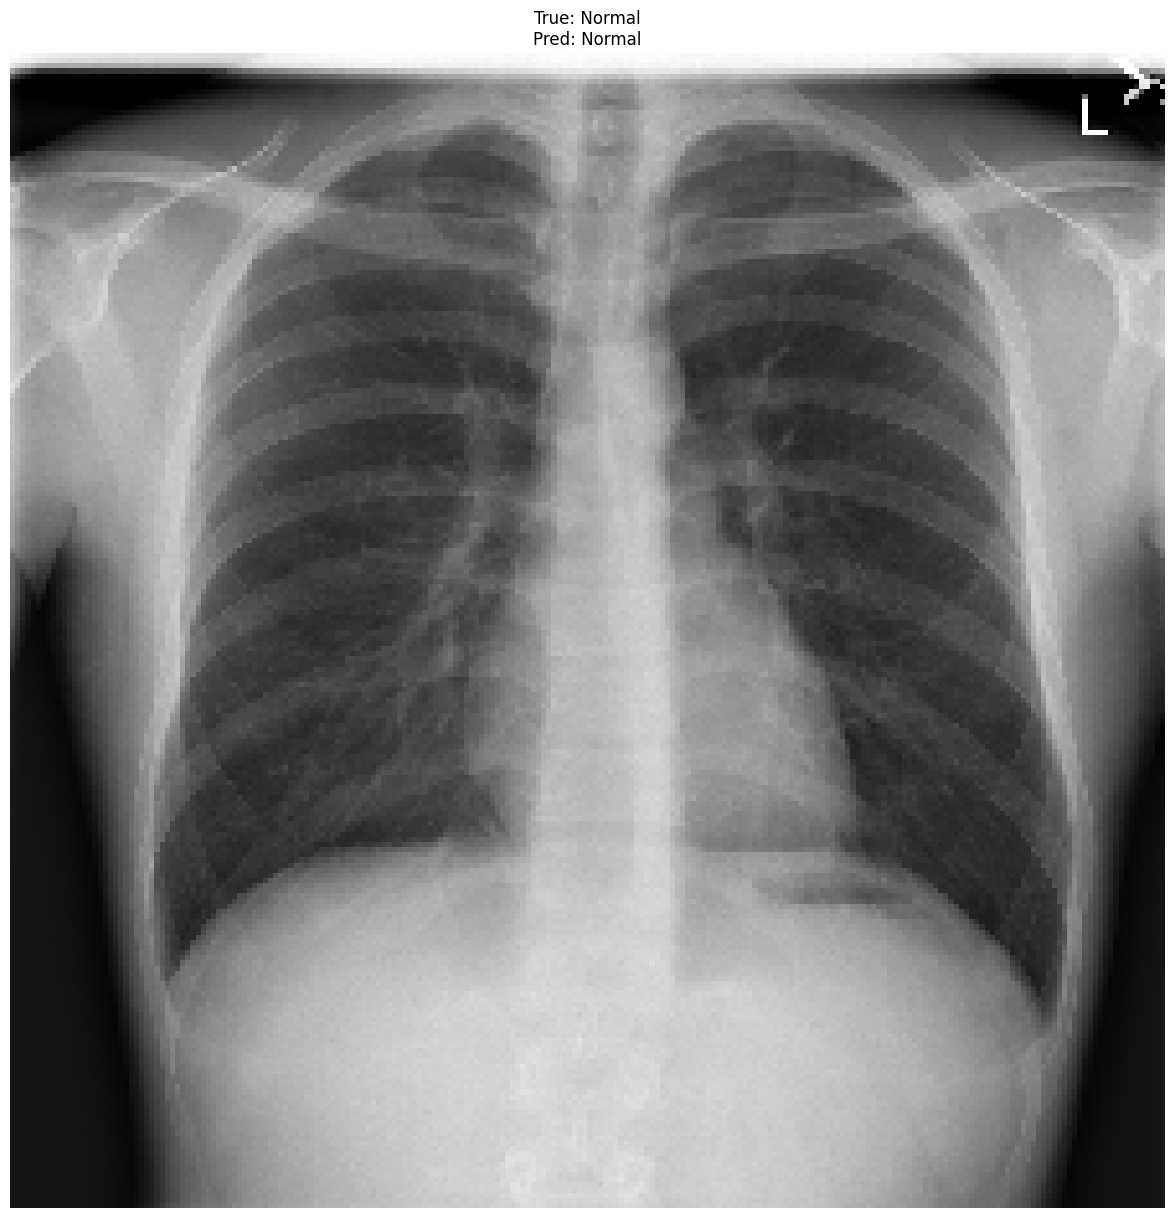

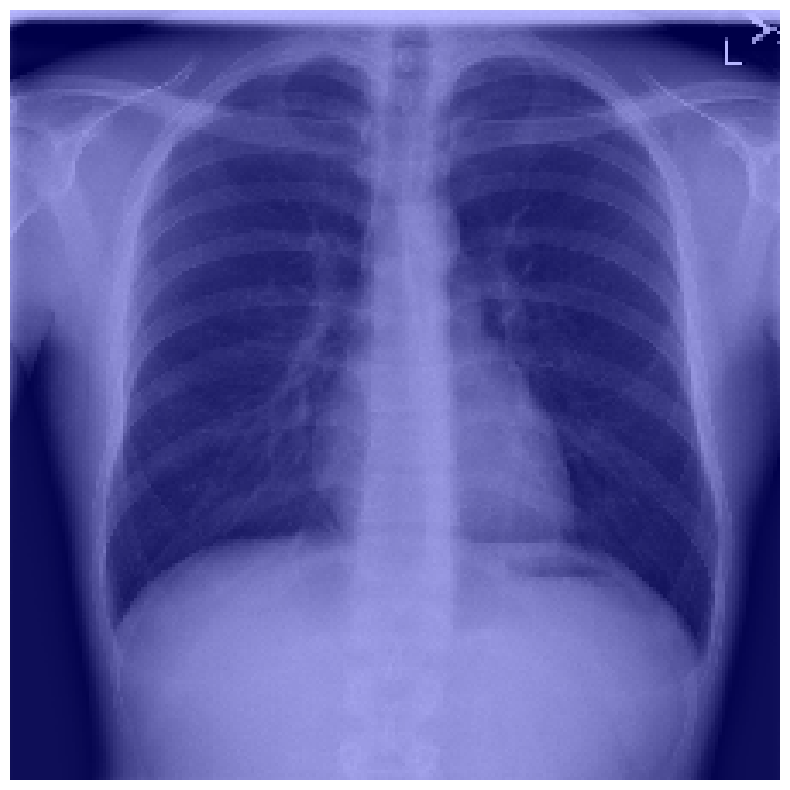

No incorrect predictions to display.


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/home/cbarr23/Documents/ccir_demo/model/cxr_classification_model.h5')

# Set the last convolutional layer name
last_conv_layer_name = 'conv2d_5'

# Get a batch of images and labels from the test set
test_images, test_labels = next(test_generator)

# Make predictions
predictions = model.predict(test_images)

# Convert predictions to binary labels
predicted_labels = (predictions > 0.5).astype(int)

# Function to display images with true and predicted labels
def display_images_with_predictions(images, true_labels, predicted_labels, num_images=5):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        if i >= len(images):  # Check if index is within range
            break
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        true_label = 'Pneumonia' if true_labels[i] == 1 else 'Normal'
        predicted_label = 'Pneumonia' if predicted_labels[i] == 1 else 'Normal'
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    plt.show()

# Grad-CAM function
def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Function to display Grad-CAM
def display_gradcam(img_array, heatmap, alpha=0.4):
    img = np.uint8(255 * img_array)
    
    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Display random samples from the test set with Grad-CAM heatmaps
num_images = 4
correct_indices = np.where(test_labels == predicted_labels)[0]
incorrect_indices = np.where(test_labels != predicted_labels)[0]

# Display correct predictions with Grad-CAM
if len(correct_indices) > 0:
    print("Correct Predictions with Grad-CAM:")
    for idx in random.sample(correct_indices.tolist(), min(num_images, len(correct_indices))):
        img_array = np.expand_dims(test_images[idx], axis=0)
        heatmap = get_gradcam_heatmap(model, img_array, last_conv_layer_name)
        display_images_with_predictions([test_images[idx]], [test_labels[idx]], [predicted_labels[idx]], 1)
        display_gradcam(test_images[idx], heatmap)
else:
    print("No correct predictions to display.")

# Display incorrect predictions with Grad-CAM
if len(incorrect_indices) > 0:
    print("Incorrect Predictions with Grad-CAM:")
    for idx in random.sample(incorrect_indices.tolist(), min(num_images, len(incorrect_indices))):
        img_array = np.expand_dims(test_images[idx], axis=0)
        heatmap = get_gradcam_heatmap(model, img_array, last_conv_layer_name)
        display_images_with_predictions([test_images[idx]], [test_labels[idx]], [predicted_labels[idx]], 1)
        display_gradcam(test_images[idx], heatmap)
else:
    print("No incorrect predictions to display.")
